# **Quantitative Evaluation Result**

We compute 4 metrics for quantitative analysis in the project: CLIP - AS, Density, Reprojection Error and CLIP - TS.


## Visualize output frames



==== Alien (1979) ====


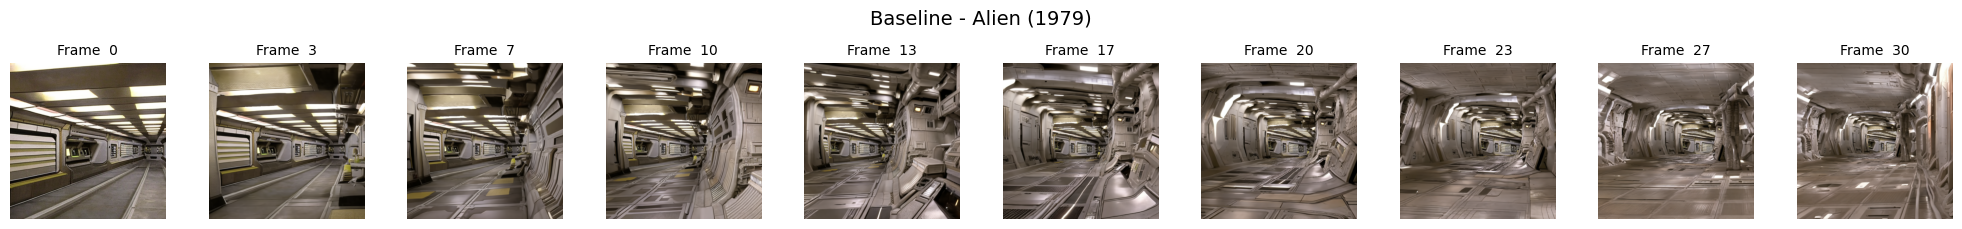

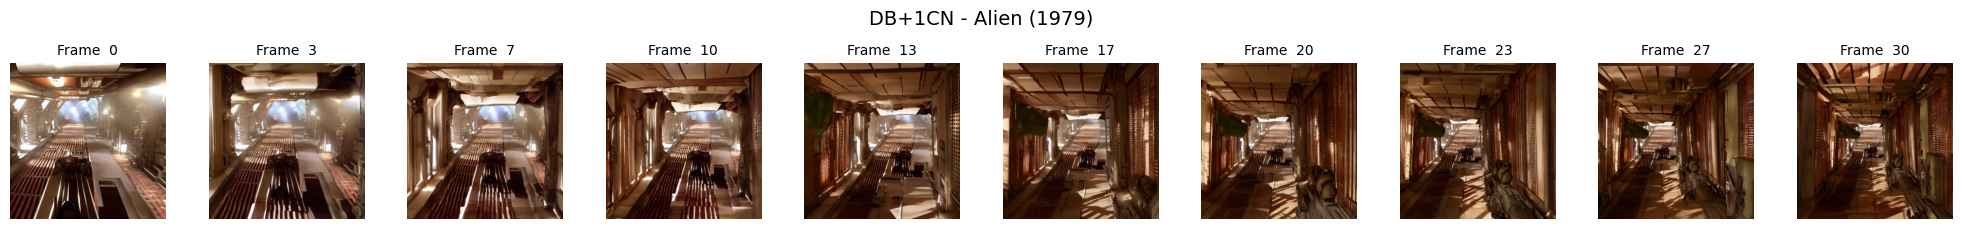

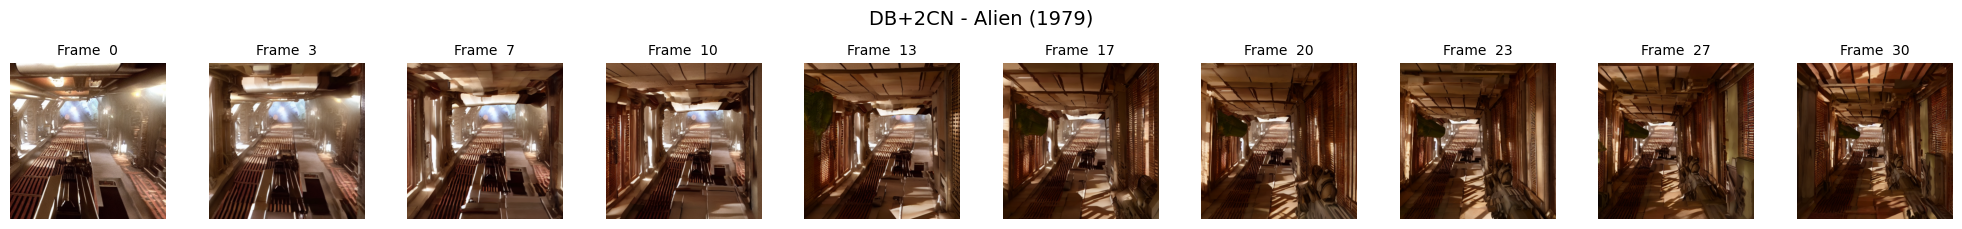


==== American Psycho (2000) ====


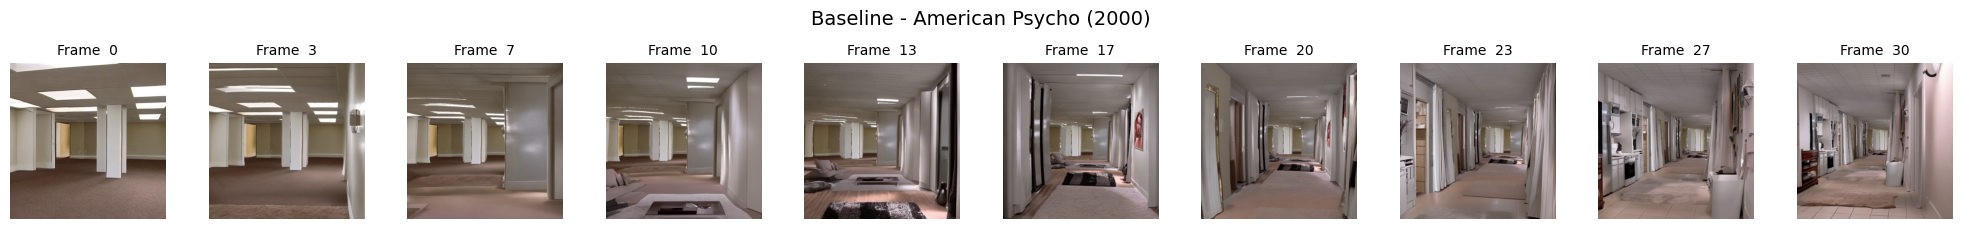

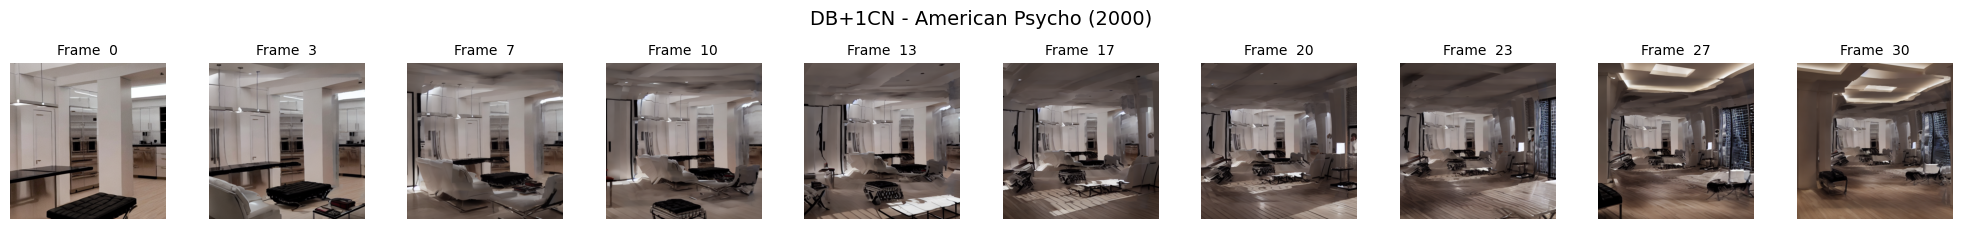

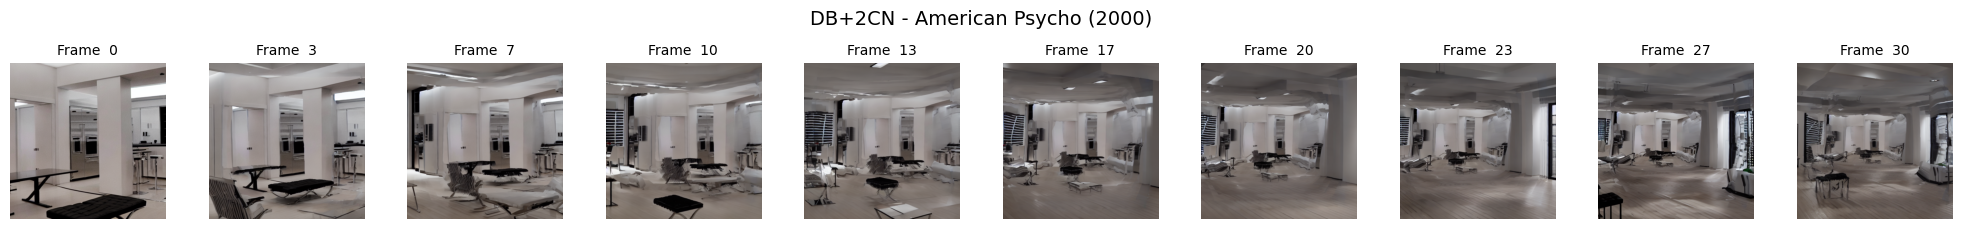


==== The Shining (1980) ====


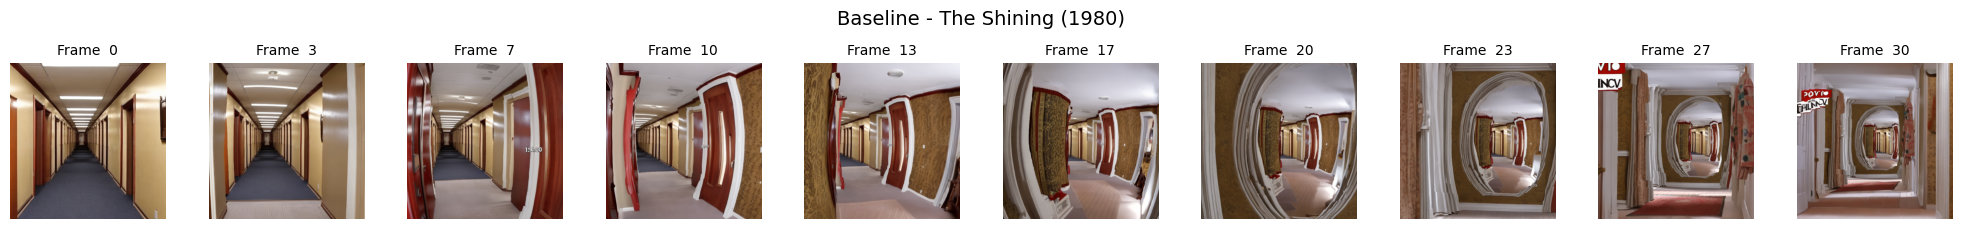

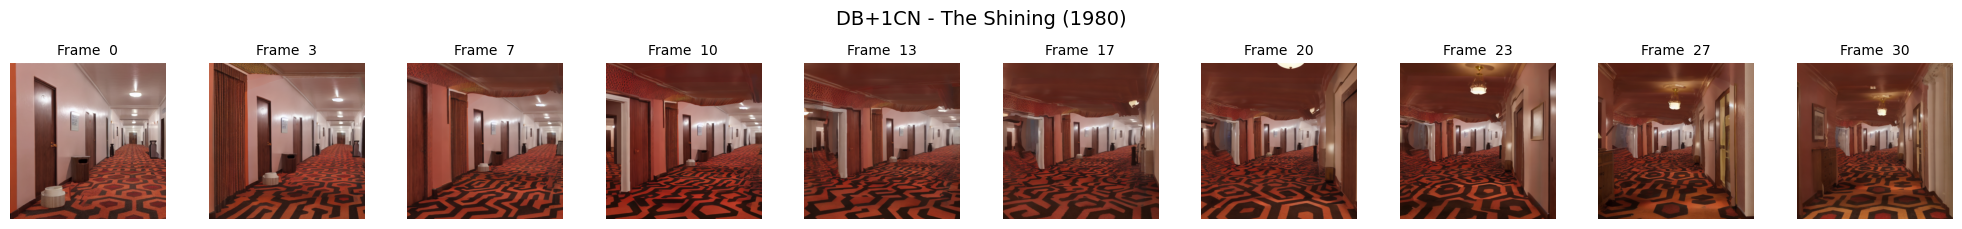

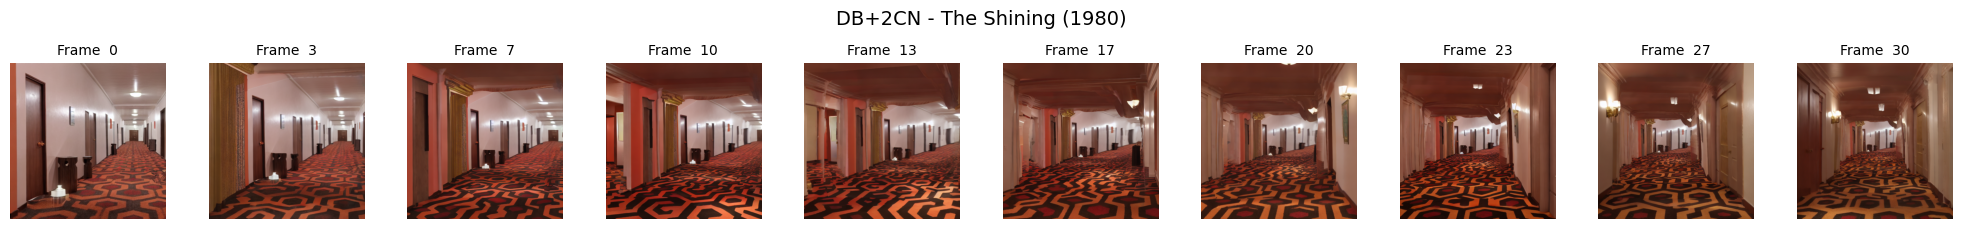


==== Passengers (2016) ====


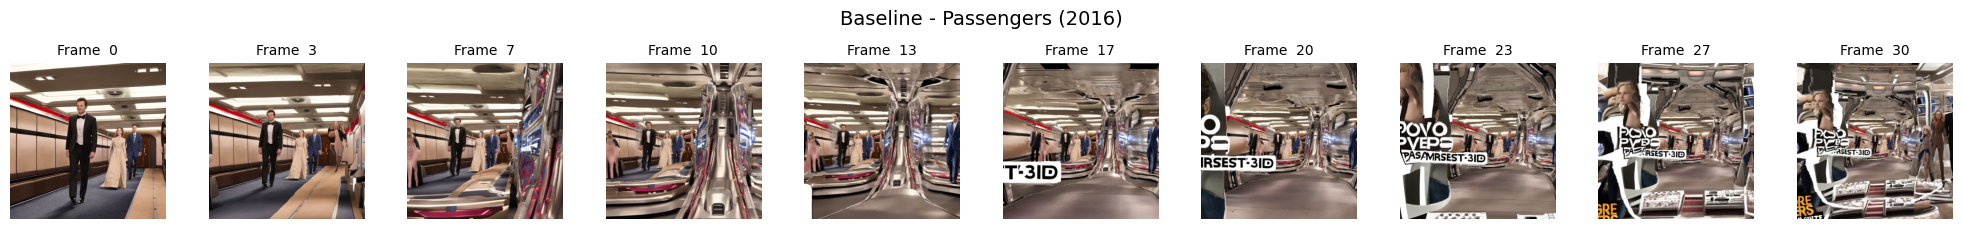

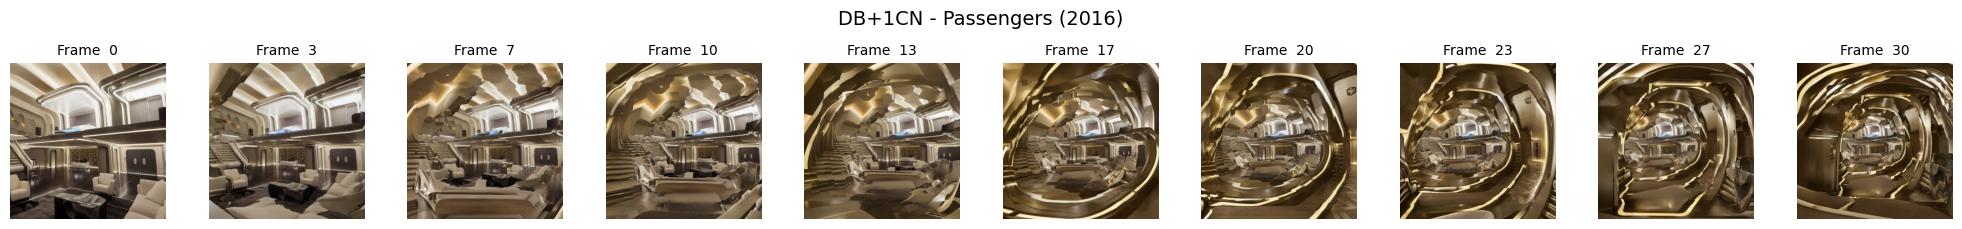

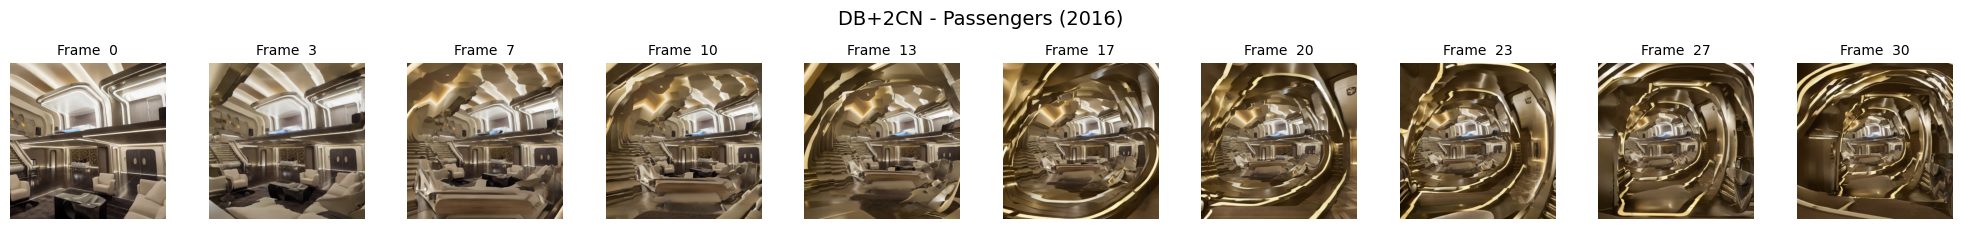


==== The Substance (2024) ====


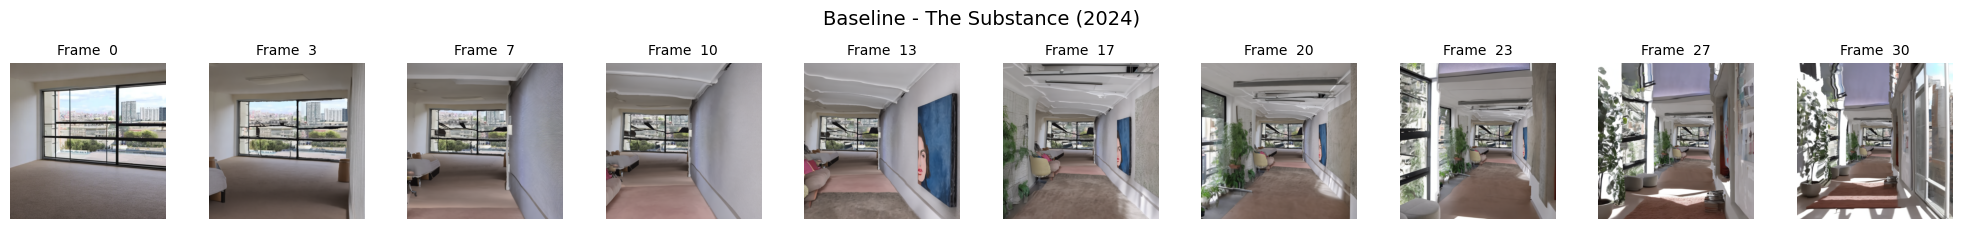

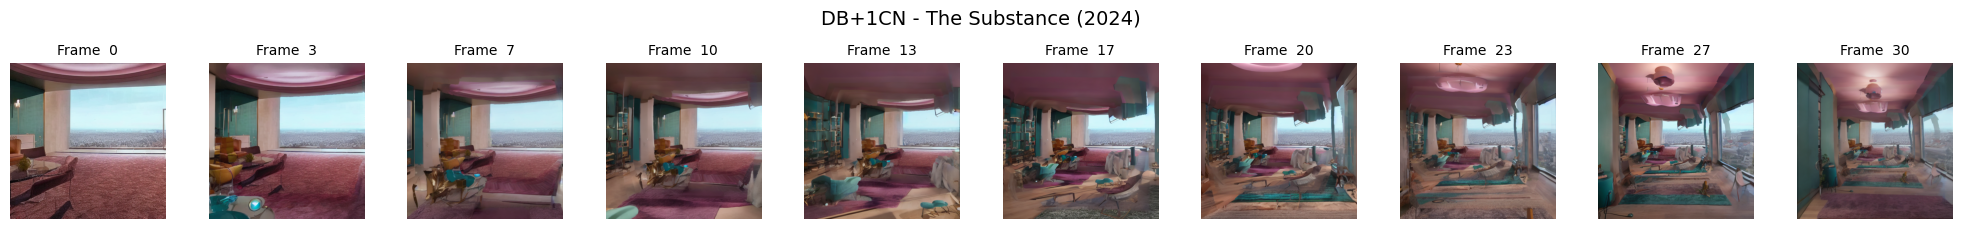

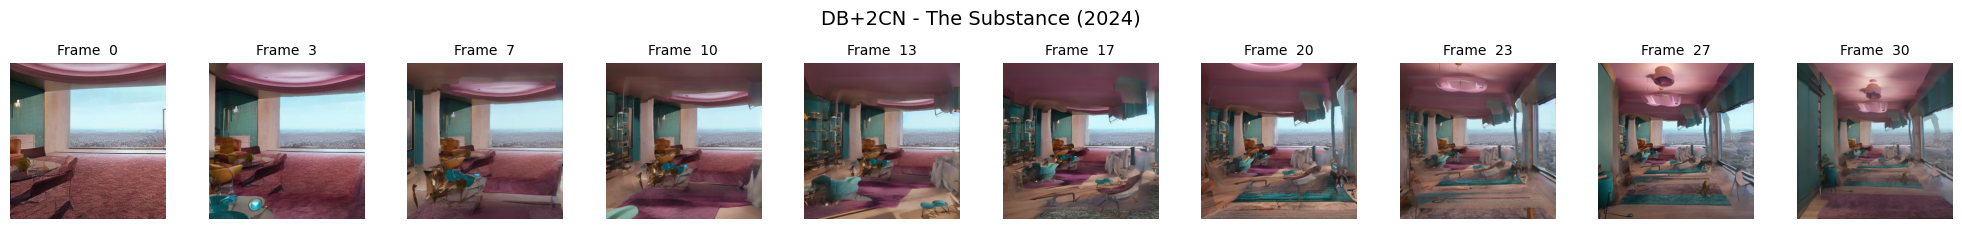

In [59]:
# ==================== Visualize selected frames from output videos ====================
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random, re

# ----------- Config -----------
BASELINE_ROOT = Path("output/Baseline")
CN1_ROOT = Path("output/CN/1CN")
CN2_ROOT = Path("output/CN/2CN")

# Base movie names (no suffix)
MOVIES = ["alien", "as", "shining", "pas", "sub"]

FRAME_SUBDIRS = ["images/frames"]
FRAME_EXTS = (".png",)
N_SHOW = 10
SAMPLE_MODE = "uniform"  # "uniform", "random", "head_tail"
RANDOM_SEED = 0
COL_WIDTH = 2.0
ROW_HEIGHT = 2.2
SHOW_TITLES = True

MOVIE_LABELS = {
    "alien": "Alien (1979)",
    "as": "American Psycho (2000)",
    "shining": "The Shining (1980)",
    "pas": "Passengers (2016)",
    "sub": "The Substance (2024)",
}


# ----- Caption Font Size -----
FRAME_TITLE_FONTSIZE = 10
MODEL_TITLE_FONTSIZE = 14  # suptitle font size for "DB+1CN: ..."
FRAME_LABEL_PREFIX = "Frame "


# ----------- Helpers -----------
def natural_key(p: Path):
    s = p.stem
    return [int(t) if t.isdigit() else t.lower() for t in re.findall(r"\d+|\D+", s)]


def frame_title_from_path(p: Path):
    m = re.search(r"\d+", p.stem)
    n = m.group(0) if m else p.stem
    return f"{FRAME_LABEL_PREFIX} {n}"


def find_frames(video_dir: Path):
    for sub in FRAME_SUBDIRS:
        d = video_dir / sub
        if not d.exists():
            continue
        paths = []
        exts = set(e.lower() for e in FRAME_EXTS) | set(e.upper() for e in FRAME_EXTS)
        for ext in exts:
            paths.extend(d.glob(f"*{ext}"))
        if paths:
            return d, sorted(paths, key=natural_key)
    return None, []


def pick_sample(paths, n, mode="uniform"):
    n = max(0, min(n, len(paths)))
    if n == 0:
        return []
    if n == len(paths):
        return paths
    if mode == "uniform":
        if n == 1:
            return [paths[0]]
        idxs = [round(i * (len(paths) - 1) / (n - 1)) for i in range(n)]
        return [paths[i] for i in idxs]
    if mode == "head_tail":
        k = n // 2
        return paths[:k] + paths[-(n - k) :]
    if mode == "random":
        random.seed(RANDOM_SEED)
        return sorted(random.sample(paths, n), key=natural_key)
    return paths[:n]


def contact_sheet_one_row(
    img_paths, title=None, col_width=2.0, row_height=2.2, show_titles=True
):
    if not img_paths:
        raise ValueError("Empty image list for grid.")
    cols = len(img_paths)
    fig, axes = plt.subplots(1, cols, figsize=(cols * col_width, row_height))
    axes = axes.ravel().tolist() if hasattr(axes, "ravel") else [axes]
    for ax, p in zip(axes, img_paths):
        ax.imshow(Image.open(p))
        if show_titles:
            ax.set_title(frame_title_from_path(p), fontsize=FRAME_TITLE_FONTSIZE)
        ax.axis("off")
    for ax in axes[len(img_paths) :]:
        ax.axis("off")
    if title:
        fig.suptitle(title, y=1.02, fontsize=MODEL_TITLE_FONTSIZE)
    plt.tight_layout()
    plt.show()


def show_variant(root: Path, folder_name: str, movie_label: str, model_label: str):
    video_dir = root / folder_name
    frames_dir, frame_paths = find_frames(video_dir)
    if not frame_paths:
        print(
            f"[skip] No frames under {video_dir}, tried {FRAME_SUBDIRS} with {FRAME_EXTS}"
        )
        return
    show_paths = pick_sample(frame_paths, N_SHOW, SAMPLE_MODE)
    title = f"{model_label} - {movie_label}"
    contact_sheet_one_row(
        show_paths,
        title=title,
        col_width=COL_WIDTH,
        row_height=ROW_HEIGHT,
        show_titles=SHOW_TITLES,
    )


# ----------- Visualize per movie: Baseline -> 1CN -> 2CN -----------
for movie in MOVIES:
    full = MOVIE_LABELS.get(movie, movie)
    print(f"\n==== {full} ====")
    show_variant(BASELINE_ROOT, movie, full, "Baseline")
    show_variant(CN1_ROOT, f"{movie}_1CN", full, "DB+1CN")
    show_variant(CN2_ROOT, f"{movie}_2CN", full, "DB+2CN")

In [ ]:
# Install CLIP if not available
%pip install git+https://github.com/openai/CLIP.git ftfy regex tqdm

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/3f/jqlfqrp51r1f0_fdhfs1qdpw0000gn/T/pip-req-build-f8sn0pvs
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/3f/jqlfqrp51r1f0_fdhfs1qdpw0000gn/T/pip-req-build-f8sn0pvs
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# ==================== Mega grid with filename-based frame header + fixed caption bands ====================
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import re, random

# ----------- Config -----------
BASELINE_ROOT = Path("output/Baseline")
CN1_ROOT = Path("output/CN/1CN")
CN2_ROOT = Path("output/CN/2CN")

# Base movie names (no suffix)
MOVIES = ["alien", "as", "shining", "pas", "sub"]

FRAME_SUBDIRS = ["images/frames"]
FRAME_EXTS = (".png",)  # tuple
N_SHOW = 8
SAMPLE_MODE = "uniform"  # "uniform", "random", "head_tail"
RANDOM_SEED = 0

# Figure sizing (overall scale)
COL_WIDTH = 2.0  # width per frame cell (inches)
IMG_ROW_HEIGHT = 2.2  # height per image row (inches)

# Only a single header row of frame numbers (no per-cell titles)
SHOW_TITLES = False

MOVIE_LABELS = {
    "alien": "Alien (1979)",
    "as": "American Psycho (2000)",
    "shining": "The Shining (1980)",
    "pas": "Passengers (2016)",
    "sub": "The Substance (2024)",
}

# ----------- Fonts -----------
GLOBAL_TITLE_FONTSIZE = 18  # font size for "Model Comparisons Across Films"
CAPTION_FONTSIZE = 12  # font size for "[Model] + Movie" rows
FRAME_HEADER_FONTSIZE = 10  # font size for the single top "Frame{N}" header row

# ----------- Spacing knobs -----------
TITLE_Y = (
    0.88  # vertical position of the big title (0..1, lower = more gap below title)
)
TOP_SPACER_RATIO = (
    0.15  # extra empty band under the title, above the frame-number header
)
HEADER_RATIO = 0.5  # height of the frame-number header row vs one image row
CAPTION_RATIO = 0.1  # height of the model+movie caption band (above images)
SPACER_RATIO = 0.05  # empty spacer band between each caption and its image row

# Gaps between subplots inside the grid (horizontal/vertical whitespace)
WSPACE = 0.02
HSPACE = 0.02

# Fallback if a filename has no integer
FRAME_INDEX_START = 0


# =================== Helpers ===================
def natural_key(p: Path):
    s = p.stem
    return [int(t) if t.isdigit() else t.lower() for t in re.findall(r"\d+|\D+", s)]


def int_in_name(p: Path):
    """Return first integer found anywhere in the filename stem, else None."""
    m = re.search(r"(\d+)", p.stem)
    return int(m.group(1)) if m else None


def find_frames(video_dir: Path):
    for sub in FRAME_SUBDIRS:
        d = video_dir / sub
        if not d.exists():
            continue
        paths = []
        exts = set(e.lower() for e in FRAME_EXTS) | set(e.upper() for e in FRAME_EXTS)
        for ext in exts:
            paths.extend(d.glob(f"*{ext}"))
        if paths:
            return d, sorted(paths, key=natural_key)
    return None, []


def pick_sample(paths, n, mode="uniform"):
    n = max(0, min(n, len(paths)))
    if n == 0:
        return []
    if n == len(paths):
        return paths
    if mode == "uniform":
        if n == 1:
            return [paths[0]]
        idxs = [round(i * (len(paths) - 1) / (n - 1)) for i in range(n)]
        return [paths[i] for i in idxs]
    if mode == "head_tail":
        k = n // 2
        return paths[:k] + paths[-(n - k) :]
    if mode == "random":
        random.seed(RANDOM_SEED)
        return sorted(random.sample(paths, n), key=natural_key)
    return paths[:n]


def get_model_samples_for_movie(movie_key: str):
    """Return dict: {model_label: [paths]} for a given movie."""
    out = {}
    # Baseline
    _, fp = find_frames(BASELINE_ROOT / movie_key)
    if fp:
        out["Baseline"] = pick_sample(fp, N_SHOW, SAMPLE_MODE)
    # DB+1CN
    _, fp = find_frames(CN1_ROOT / f"{movie_key}_1CN")
    if fp:
        out["DB+1CN"] = pick_sample(fp, N_SHOW, SAMPLE_MODE)
    # DB+2CN
    _, fp = find_frames(CN2_ROOT / f"{movie_key}_2CN")
    if fp:
        out["DB+2CN"] = pick_sample(fp, N_SHOW, SAMPLE_MODE)
    return out


def header_labels_from_rows(row_specs):
    """
    Build the single header labels using real frame numbers from filenames.
    Strategy: take the first row that has paths, extract integers from its N_SHOW samples.
    Fallback to index if a name has no number.
    """
    for _movie_title, _model_label, paths in row_specs:
        if paths:
            labels = []
            for i in range(min(N_SHOW, len(paths))):
                n = int_in_name(paths[i])
                labels.append(n if n is not None else (FRAME_INDEX_START + i))
            while len(labels) < N_SHOW:
                labels.append(FRAME_INDEX_START + len(labels))
            return labels
    return [FRAME_INDEX_START + i for i in range(N_SHOW)]


# =================== Renderer ===================
def show_full_grid_with_caption_bands():
    """
    Grid layout (rows):
      0:     top spacer band (empty, lets you push header downward under title)
      1:     header "Frame{n}" across columns (one time only, from real filenames)
      For each (movie, model) set:
         cap:     caption band (spans all columns) "[Model] + Movie"
         spacer:  empty band under caption
         images:  N_SHOW subplots with the frames
    """
    # Build ordered rows: movie-major, fixed model order
    sets = []  # list of (movie_title, model_label, paths)
    for movie_key in MOVIES:
        title = MOVIE_LABELS.get(movie_key, movie_key)
        samples = get_model_samples_for_movie(movie_key)
        for model_label in ["Baseline", "DB+1CN", "DB+2CN"]:
            if model_label in samples:
                sets.append((title, model_label, samples[model_label]))

    if not sets:
        print("[skip] No frames found for any movie.")
        return

    import matplotlib.pyplot as plt

    fig_cols = N_SHOW
    fig_width = fig_cols * COL_WIDTH

    n_sets = len(sets)  # up to 15
    # Total height units across all bands:
    total_units = (
        TOP_SPACER_RATIO + HEADER_RATIO + n_sets * (CAPTION_RATIO + SPACER_RATIO + 1.0)
    )
    fig_height = total_units * IMG_ROW_HEIGHT

    fig = plt.figure(figsize=(fig_width, fig_height), constrained_layout=True)
    gs = fig.add_gridspec(
        nrows=1 + 1 + n_sets * 3,  # top spacer + header + (caption, spacer, image)*sets
        ncols=fig_cols,
        height_ratios=[TOP_SPACER_RATIO, HEADER_RATIO]
        + sum(([CAPTION_RATIO, SPACER_RATIO, 1.0] for _ in range(n_sets)), []),
        wspace=WSPACE,
        hspace=HSPACE,
    )

    # ---- Title and its spacing ----
    fig.suptitle(
        "SAMPLE OUTPUT FRAMES BY FILM AND MODEL",
        y=TITLE_Y,
        fontsize=GLOBAL_TITLE_FONTSIZE,
    )

    # ---- Single header row (filename-based) ----
    frame_nums = header_labels_from_rows(sets)  # list of ints from filenames
    header_row_index = 1  # row 0 is the top spacer band
    for c in range(fig_cols):
        ax = fig.add_subplot(gs[header_row_index, c])
        ax.axis("off")
        # No space: "Frame{n}"
        ax.text(
            0.5,
            0.5,
            f"[Frame {frame_nums[c]}]",
            ha="center",
            va="center",
            fontsize=FRAME_HEADER_FONTSIZE,
        )

    # ---- For each set: caption band, spacer band, image row ----
    for i, (movie_title, model_label, paths) in enumerate(sets):
        base = 2 + i * 3  # starts after top spacer + header

        # Caption band spanning all columns
        cap_ax = fig.add_subplot(gs[base, :])
        cap_ax.axis("off")
        cap_ax.text(
            0.5,
            0.5,
            f"{model_label} - {movie_title}",
            ha="center",
            va="center",
            fontsize=CAPTION_FONTSIZE,
            fontweight="bold",
        )

        # Spacer band (empty) between caption and images
        spacer_ax = fig.add_subplot(gs[base + 1, :])
        spacer_ax.axis("off")

        # Image row (N_SHOW subplots)
        for c in range(fig_cols):
            ax = fig.add_subplot(gs[base + 2, c])
            ax.axis("off")
            if c < len(paths):
                try:
                    img = Image.open(paths[c])
                    ax.imshow(img)
                except Exception as e:
                    ax.text(0.5, 0.5, f"Err\n{e}", ha="center", va="center", fontsize=8)

    plt.show()


# ----------- Run -----------
if __name__ == "__main__":
    show_full_grid_with_caption_bands()

## CLIP - AS


In [ ]:
# ============== CLIP-Aesthetic— OpenAI CLIP ViT-B/32 ==============
from pathlib import Path
import re, urllib.request, torch, numpy as np, pandas as pd
from PIL import Image

# ---- Set folder paths for output videos ----
GROUPS = {
    "Baseline": Path("output/Baseline"),
    "1CN": Path("output/CN/1CN"),
    "2CN": Path("output/CN/2CN"),
}
VIDEOS = {
    "Baseline": ["alien", "as", "shining", "pas", "sub"],
    "1CN": ["alien_1CN", "as_1CN", "shining_1CN", "pas_1CN", "sub_1CN"],
    "2CN": ["alien_2CN", "as_2CN", "shining_2CN", "pas_2CN", "sub_2CN"],
}

FRAME_SUBDIRS = ["images/frames"]
FRAME_EXTS = (".png",)
USE_ALL_31_FRAMES = True  # False -> use frame 0 to 29; True -> use frames 0 to 30
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH = 32

# ---- Load CLIP (OpenAI) ----
try:
    import clip
except ModuleNotFoundError:
    raise SystemExit("CLIP not installed")
model, preprocess = clip.load("ViT-B/32", device=DEVICE)
model.eval()


# ---- Load LAION aesthetic head (ViT-B/32, 512->1) ----
def load_aesthetic_head_vit_b32(device=DEVICE):
    cache_dir = Path.home() / ".cache" / "emb_reader"
    cache_dir.mkdir(parents=True, exist_ok=True)
    weight_path = cache_dir / "sa_0_4_vit_b_32_linear.pth"
    if not weight_path.exists():
        url = "https://github.com/LAION-AI/aesthetic-predictor/blob/main/sa_0_4_vit_b_32_linear.pth?raw=true"
        print(f"Downloading LAION aesthetic head to {weight_path} ...")
        urllib.request.urlretrieve(url, weight_path.as_posix())
    head = torch.nn.Linear(512, 1)
    state = torch.load(weight_path, map_location=device)
    head.load_state_dict(state)
    return head.to(device).eval()


aesthetic_head = load_aesthetic_head_vit_b32()


# ---- Helpers ----
def natural_key(p: Path):
    s = p.stem
    return [int(t) if t.isdigit() else t.lower() for t in re.findall(r"\d+|\D+", s)]


def find_frames_dir(video_dir: Path):
    for sub in FRAME_SUBDIRS:
        d = video_dir / sub
        if d.exists():
            return d
    return None


def list_frames_sorted(frames_dir: Path):
    paths = []
    for ext in FRAME_EXTS:
        paths.extend(frames_dir.glob(f"*{ext}"))
    return sorted(paths, key=natural_key)


def select_eval_frames(paths):
    return paths[:31] if USE_ALL_31_FRAMES else paths[:30]


@torch.no_grad()
def embed_images(paths):
    embs = []
    for i in range(0, len(paths), BATCH):
        batch = paths[i : i + BATCH]
        imgs = [preprocess(Image.open(p).convert("RGB")) for p in batch]
        x = torch.stack(imgs).to(DEVICE)
        z = model.encode_image(x)  # [N,512]
        z = z / z.norm(dim=-1, keepdim=True)  # normalize
        embs.append(z)
    return torch.cat(embs, 0) if embs else torch.empty(0, device=DEVICE)


@torch.no_grad()
def aesthetic_mean(paths):
    if not paths:
        return np.nan
    z = embed_images(paths)
    s = aesthetic_head(z).reshape(-1)  # [N]
    return float(s.detach().float().cpu().mean())


# ---- Compute CLIP-AS mean per (group, video) ----
rows = []
for g, root in GROUPS.items():
    for v in VIDEOS.get(g, []):
        vdir = root / v
        fdir = find_frames_dir(vdir)
        if not fdir:
            print(f"[skip] {g}/{v}: no frames dir (tried {FRAME_SUBDIRS})")
            continue
        eval_frames = select_eval_frames(list_frames_sorted(fdir))
        if not eval_frames:
            print(f"[skip] {g}/{v}: no frames found")
            continue
        rows.append(
            {"group": g, "video": v, "clip_as_mean": aesthetic_mean(eval_frames)}
        )

summary = pd.DataFrame(rows).sort_values(["video", "group"]).reset_index(drop=True)

# ---- Compare by movie (Baseline vs 1CN vs 2CN + Δ vs Baseline) ----
pat = re.compile(r"[_-]?(?:1cn|2cn|cn1|cn2)$", flags=re.IGNORECASE)
summary["movie"] = summary["video"].apply(lambda s: pat.sub("", s))

mean_wide = summary.pivot_table(
    index="movie", columns="group", values="clip_as_mean", aggfunc="mean"
)
for c in ["Baseline", "1CN", "2CN"]:
    if c not in mean_wide.columns:
        mean_wide[c] = np.nan

mean_cmp = pd.DataFrame(
    {
        "Baseline": mean_wide["Baseline"],
        "1CN": mean_wide["1CN"],
        "Δ1CN vs Base": mean_wide["1CN"] - mean_wide["Baseline"],
        "2CN": mean_wide["2CN"],
        "Δ2CN vs Base": mean_wide["2CN"] - mean_wide["Baseline"],
    }
).sort_index()


try:
    base_order = [re.sub(pat, "", v) for v in VIDEOS["Baseline"]] or list(
        mean_cmp.index
    )
    mean_cmp = mean_cmp.reindex(base_order)
except Exception:
    pass

pd.set_option("display.precision", 3)
print("CLIP-AS (mean) by movie — - Higher is better - Δ vs Baseline:")
display(mean_cmp.round(3))

# ---- Model means (Baseline, 1CN, 2CN) ----
print("\nModel means (CLIP-AS mean) - Higher is better:")
display(
    summary.groupby("group")[["clip_as_mean"]]
    .mean()
    .reindex(["Baseline", "1CN", "2CN"])
    .round(3)
)

CLIP-AS (mean) by movie — - Higher is better - Δ vs Baseline:


Baseline    1CN  Δ1CN vs Base    2CN  Δ2CN vs Base
movie                                                      
alien       6.043  5.306        -0.737  5.332        -0.711
as          5.195  5.339         0.145  5.262         0.067
shining     4.882  5.539         0.656  5.665         0.782
pas         4.620  5.615         0.995  5.615         0.995
sub         4.927  6.088         1.161  6.088         1.161


Model means (CLIP-AS mean) - Higher is better:


clip_as_mean
group                 
Baseline         5.133
1CN              5.577
2CN              5.592

In [ ]:
from typing import Optional

## 3D Consistency (COLMAP)


### Density


In [ ]:
# ===== Density comparison (higher is better) =====
from pathlib import Path
from typing import Optional
import os, shutil, subprocess, numpy as np, pandas as pd, re

USE_CPU = True
FRAME_SUBDIRS = ["images/frames", "frames"]

# --- COLMAP setup ---
os.environ["PATH"] = "/opt/homebrew/bin:" + os.environ.get("PATH", "")
COLMAP_EXE = shutil.which("colmap") or "/opt/homebrew/bin/colmap"
if not shutil.which(COLMAP_EXE):
    raise SystemExit("COLMAP not found. Install it or fix COLMAP_EXE.")


def _run(cmd, cwd=None):
    kw = dict(check=True, cwd=cwd, text=True)
    if USE_CPU:
        if "feature_extractor" in cmd:
            cmd += ["--SiftExtraction.use_gpu", "0"]
        if "exhaustive_matcher" in cmd:
            cmd += ["--SiftMatching.use_gpu", "0"]
    return subprocess.run(cmd, **kw)


def find_frames_dir(video_dir: Path) -> Optional[Path]:
    for sub in FRAME_SUBDIRS:
        d = video_dir / sub
        if d.exists():
            return d
    return None


def ensure_sparse_and_txt(vdir: Path, fdir: Path) -> Optional[Path]:
    out_root = vdir / "colmap_sparse_est"
    db = out_root / "database.db"
    sparse = out_root / "sparse"
    sparse.mkdir(parents=True, exist_ok=True)

    if not db.exists():
        _run(
            [
                COLMAP_EXE,
                "feature_extractor",
                "--database_path",
                str(db),
                "--image_path",
                str(fdir),
                "--ImageReader.single_camera",
                "1",
            ]
        )
    flag = out_root / ".matching_done"
    if not flag.exists():
        _run([COLMAP_EXE, "exhaustive_matcher", "--database_path", str(db)])
        flag.write_text("ok")

    models = sorted([p for p in sparse.glob("*") if p.is_dir()], key=lambda p: p.name)
    if not models:
        _run(
            [
                COLMAP_EXE,
                "mapper",
                "--database_path",
                str(db),
                "--image_path",
                str(fdir),
                "--output_path",
                str(sparse),
            ]
        )
        models = sorted(
            [p for p in sparse.glob("*") if p.is_dir()], key=lambda p: p.name
        )
        if not models:
            print(f"[warn] mapper produced no models for {vdir}")
            return None
    model_dir = models[0]

    txt_dir = out_root / "sparse_txt"
    if not (txt_dir / "images.txt").exists():
        txt_dir.mkdir(parents=True, exist_ok=True)
        _run(
            [
                COLMAP_EXE,
                "model_converter",
                "--input_path",
                str(model_dir),
                "--output_path",
                str(txt_dir),
                "--output_type",
                "TXT",
            ]
        )
    return txt_dir if (txt_dir / "images.txt").exists() else None


# --- TXT parsers + coverage metric ---
def parse_cameras(cameras_txt: Path):
    cams = {}
    with open(cameras_txt, "r") as f:
        for ln in f:
            ln = ln.strip()
            if not ln or ln.startswith("#"):
                continue
            parts = ln.split()
            cam_id = int(parts[0])
            w, h = int(parts[2]), int(parts[3])
            cams[cam_id] = {"w": w, "h": h}
    return cams


def parse_images(images_txt: Path):
    imgs = {}
    lines = (images_txt.read_text(encoding="utf-8", errors="ignore")).splitlines()
    lines = [ln.strip() for ln in lines if ln.strip() and not ln.startswith("#")]
    i = 0
    while i < len(lines):
        meta = lines[i].split()
        img_id = int(meta[0])
        cam_id = int(meta[8])
        pts = []
        if i + 1 < len(lines):
            coords = lines[i + 1].split()
            for j in range(0, len(coords), 3):
                x = float(coords[j])
                y = float(coords[j + 1])
                pid = int(coords[j + 2])
                pts.append((x, y, pid))
        imgs[img_id] = {"cam_id": cam_id, "pts": pts}
        i += 2
    return imgs


def sparse_grid_coverage_percent(txt_dir: Path, grid=20) -> float:
    cams = parse_cameras(txt_dir / "cameras.txt")
    imgs = parse_images(txt_dir / "images.txt")
    covs = []
    for img in imgs.values():
        cam = cams[img["cam_id"]]
        w, h = cam["w"], cam["h"]
        cells = set()
        for x, y, pid in img["pts"]:
            if pid == -1:
                continue
            ci = min(grid - 1, max(0, int(x / w * grid)))
            cj = min(grid - 1, max(0, int(y / h * grid)))
            cells.add((ci, cj))
        covs.append(100.0 * len(cells) / (grid * grid))
    return float(np.mean(covs)) if covs else np.nan


# --- Build table (Baseline vs 1CN vs 2CN + deltas) ---
rows = []
for g, root in GROUPS.items():
    for v in VIDEOS.get(g, []):
        vdir = root / v
        fdir = find_frames_dir(vdir)
        if not fdir:
            print(f"[skip] {g}/{v}: no frames dir")
            continue
        txt_dir = vdir / "colmap_sparse_est" / "sparse_txt"
        if not (txt_dir / "images.txt").exists():
            print(f"[info] {g}/{v}: running COLMAP sparse to get TXT...")
            txt_dir = ensure_sparse_and_txt(vdir, fdir) or None
        if not txt_dir:
            print(f"[skip] {g}/{v}: missing TXT")
            continue
        cov = sparse_grid_coverage_percent(txt_dir, grid=20)
        rows.append({"group": g, "video": v, "density_cov_%": cov})

summary = pd.DataFrame(rows)

# ---- CLIP-AS-style comparison ----
if summary.empty:
    print("No density data to display.")
else:
    pat = re.compile(r"[_-]?(?:1cn|2cn|cn1|cn2)$", flags=re.IGNORECASE)
    summary["movie"] = summary["video"].apply(lambda s: pat.sub("", s))

    mean_wide = summary.pivot_table(
        index="movie", columns="group", values="density_cov_%", aggfunc="mean"
    )
    for c in ["Baseline", "1CN", "2CN"]:
        if c not in mean_wide.columns:
            mean_wide[c] = np.nan

    mean_cmp = pd.DataFrame(
        {
            "Baseline": mean_wide["Baseline"],
            "1CN": mean_wide["1CN"],
            "Δ1CN vs Base": mean_wide["1CN"] - mean_wide["Baseline"],
            "2CN": mean_wide["2CN"],
            "Δ2CN vs Base": mean_wide["2CN"] - mean_wide["Baseline"],
        }
    ).sort_index()

    try:
        base_order = [re.sub(pat, "", v) for v in VIDEOS["Baseline"]] or list(
            mean_cmp.index
        )
        mean_cmp = mean_cmp.reindex(base_order)
    except Exception:
        pass

    pd.set_option("display.precision", 3)
    print(
        "Density (sparse grid coverage %) by movie — Higher is better — Δ vs Baseline:"
    )
    display(mean_cmp.round(3))

    print("\nModel means (Density, coverage %) — Higher is better:")
    display(
        summary.groupby("group")[["density_cov_%"]]
        .mean()
        .reindex(["Baseline", "1CN", "2CN"])
        .round(3)
    )

Density (sparse grid coverage %) by movie — Higher is better — Δ vs Baseline:


Baseline     1CN  Δ1CN vs Base     2CN  Δ2CN vs Base
movie                                                        
alien      21.167  14.250        -6.917  21.417         0.250
as         41.333  49.000         7.667  38.250        -3.083
shining    23.167  43.625        20.458  46.282        23.116
pas         9.167  58.492        49.325  37.050        27.883
sub        37.167  42.685         5.519  42.815         5.648


Model means (Density, coverage %) — Higher is better:


density_cov_%
group                  
Baseline         26.400
1CN              41.610
2CN              37.163

### Reprojection error


In [ ]:
# === Reprojection error — px / lower is better ===
from pathlib import Path
import subprocess, shutil, os, re
from typing import Optional, Dict, Tuple, List
import numpy as np
import pandas as pd

# ---------- Config ----------
GROUPS = {
    "Baseline": Path("output/Baseline"),
    "1CN": Path("output/CN/1CN"),
    "2CN": Path("output/CN/2CN"),
}
VIDEOS = {
    "Baseline": ["alien", "as", "shining", "pas", "sub"],
    "1CN": ["alien_1CN", "as_1CN", "shining_1CN", "pas_1CN", "sub_1CN"],
    "2CN": ["alien_2CN", "as_2CN", "shining_2CN", "pas_2CN", "sub_2CN"],
}
FRAME_SUBDIRS = ["images/frames", "frames"]  # search order

# COLMAP binary (CPU)
os.environ["PATH"] = "/opt/homebrew/bin:" + os.environ.get("PATH", "")
COLMAP_EXE = shutil.which("colmap") or "/opt/homebrew/bin/colmap"
assert shutil.which(COLMAP_EXE), "COLMAP not found on PATH"


def _run(cmd: List[str], cwd: Optional[Path] = None):
    return subprocess.run(cmd, check=True, text=True, cwd=str(cwd) if cwd else None)


def find_frames_dir(video_dir: Path) -> Optional[Path]:
    for sub in FRAME_SUBDIRS:
        d = video_dir / sub
        if d.exists():
            return d
    return None


def ensure_sparse_txt(vdir: Path, fdir: Path) -> Optional[Path]:
    """
    Minimal, SceneScape-compatible sparse SfM + TXT export (default-ish flags).
    Uses sequential matcher if available; falls back to exhaustive.
    """
    out_root = vdir / "colmap_sparse_est"
    db = out_root / "database.db"
    sparse = out_root / "sparse"
    txt = out_root / "sparse_txt"
    out_root.mkdir(parents=True, exist_ok=True)
    sparse.mkdir(parents=True, exist_ok=True)

    try:
        if not db.exists():
            _run(
                [
                    COLMAP_EXE,
                    "feature_extractor",
                    "--database_path",
                    str(db),
                    "--image_path",
                    str(fdir),
                    "--ImageReader.single_camera",
                    "1",
                    "--SiftExtraction.use_gpu",
                    "0",
                ]
            )
        try:
            _run(
                [
                    COLMAP_EXE,
                    "sequential_matcher",
                    "--database_path",
                    str(db),
                    "--SiftMatching.use_gpu",
                    "0",
                ]
            )
        except subprocess.CalledProcessError:
            _run(
                [
                    COLMAP_EXE,
                    "exhaustive_matcher",
                    "--database_path",
                    str(db),
                    "--SiftMatching.use_gpu",
                    "0",
                ]
            )

        _run(
            [
                COLMAP_EXE,
                "mapper",
                "--database_path",
                str(db),
                "--image_path",
                str(fdir),
                "--output_path",
                str(sparse),
            ]
        )

        models = sorted(
            [p for p in sparse.glob("*") if p.is_dir()], key=lambda p: p.name
        )
        if not models:
            return None

        txt.mkdir(parents=True, exist_ok=True)
        _run(
            [
                COLMAP_EXE,
                "model_converter",
                "--input_path",
                str(models[0]),
                "--output_path",
                str(txt),
                "--output_type",
                "TXT",
            ]
        )

        need = ["cameras.txt", "images.txt", "points3D.txt"]
        if not all((txt / n).exists() for n in need):
            return None
        return txt
    except subprocess.CalledProcessError:
        return None


# ---------- TXT parsers ----------
def parse_cameras(cameras_txt: Path) -> Dict[int, dict]:
    cams = {}
    with open(cameras_txt, "r") as f:
        for ln in f:
            ln = ln.strip()
            if not ln or ln.startswith("#"):
                continue
            parts = ln.split()
            cam_id = int(parts[0])
            model = parts[1]
            w, h = int(parts[2]), int(parts[3])
            params = list(map(float, parts[4:]))
            cams[cam_id] = {"model": model, "w": w, "h": h, "p": params}
    return cams


def parse_images(images_txt: Path) -> Dict[int, dict]:
    imgs = {}
    lines = images_txt.read_text(encoding="utf-8", errors="ignore").splitlines()
    lines = [ln.strip() for ln in lines if ln.strip() and not ln.startswith("#")]
    i = 0
    while i < len(lines):
        meta = lines[i].split()
        img_id = int(meta[0])
        q = tuple(map(float, meta[1:5]))
        t = tuple(map(float, meta[5:8]))
        cam_id = int(meta[8])
        name = " ".join(meta[9:])
        pts = []
        if i + 1 < len(lines):
            coords = lines[i + 1].split()
            for j in range(0, len(coords), 3):
                x = float(coords[j])
                y = float(coords[j + 1])
                pid = int(coords[j + 2])
                pts.append((x, y, pid))
        imgs[img_id] = {"cam_id": cam_id, "q": q, "t": t, "name": name, "pts": pts}
        i += 2
    return imgs


def parse_points(points_txt: Path) -> Dict[int, Tuple[float, float, float]]:
    pts3d = {}
    with open(points_txt, "r") as f:
        for ln in f:
            ln = ln.strip()
            if not ln or ln.startswith("#"):
                continue
            parts = ln.split()
            pid = int(parts[0])
            X, Y, Z = map(float, parts[1:4])
            pts3d[pid] = (X, Y, Z)
    return pts3d


# ---------- Geometry ----------
def q_to_R(qw, qx, qy, qz):
    ww, xx, yy, zz = qw, qx, qy, qz
    return np.array(
        [
            [
                1 - 2 * (yy * yy + zz * zz),
                2 * (xx * yy - ww * zz),
                2 * (xx * zz + ww * yy),
            ],
            [
                2 * (xx * yy + ww * zz),
                1 - 2 * (xx * xx + zz * zz),
                2 * (yy * zz - ww * xx),
            ],
            [
                2 * (xx * zz - ww * yy),
                2 * (yy * zz + ww * xx),
                1 - 2 * (xx * xx + yy * yy),
            ],
        ],
        dtype=np.float64,
    )


def project_point(cam, R, t, XYZ):
    X = np.array(XYZ, dtype=np.float64)
    Xc = R @ X + np.array(t, dtype=np.float64)
    Z = Xc[2]
    if Z <= 1e-9:
        return None
    x, y = Xc[0] / Z, Xc[1] / Z

    model = cam["model"].upper()
    p = cam["p"]
    if model == "PINHOLE":
        fx, fy, cx, cy = p
    elif model == "SIMPLE_PINHOLE":
        f, cx, cy = p
        fx = fy = f
    elif model == "SIMPLE_RADIAL":
        f, cx, cy, k1 = p
        fx = fy = f
        r2 = x * x + y * y
        scale = 1 + k1 * r2
        x *= scale
        y *= scale
    elif model == "RADIAL":
        f, cx, cy, k1, k2 = p
        fx = fy = f
        r2 = x * x + y * y
        s = 1 + k1 * r2 + k2 * r2 * r2
        x *= s
        y *= s
    elif model == "OPENCV":
        fx, fy, cx, cy, k1, k2, p1, p2, k3, k4, k5, k6 = (p + [0] * 12)[:12]
        r2 = x * x + y * y
        r4 = r2 * r2
        r6 = r4 * r2
        radial = (1 + k1 * r2 + k2 * r4 + k3 * r6) / max(
            1e-12, (1 + k4 * r2 + k5 * r4 + k6 * r6)
        )
        xr, yr = x * radial, y * radial
        xt = 2 * p1 * x * y + p2 * (r2 + 2 * x * x)
        yt = p1 * (r2 + 2 * y * y) + 2 * p2 * x * y
        x, y = xr + xt, yr + yt
    else:
        if len(p) >= 3:
            f, cx, cy = p[0], p[1], p[2]
            fx = fy = f
        else:
            return None

    u, v = fx * x + cx, fy * y + cy
    return (u, v)


def mean_reproj_px_from_txt(txt_dir: Path) -> float:
    cams = parse_cameras(txt_dir / "cameras.txt")
    imgs = parse_images(txt_dir / "images.txt")
    pts3d = parse_points(txt_dir / "points3D.txt")
    errs: List[float] = []
    for img in imgs.values():
        cam = cams.get(img["cam_id"])
        if cam is None:
            continue
        R = q_to_R(*img["q"])
        t = img["t"]
        for xo, yo, pid in img["pts"]:
            if pid == -1:
                continue
            P = pts3d.get(pid)
            if P is None:
                continue
            uv = project_point(cam, R, t, P)
            if uv is None:
                continue
            u, v = uv
            errs.append(np.hypot(u - xo, v - yo))
    return float(np.mean(errs)) if errs else np.nan


# ---------- Main ----------
rows = []
for g, root in GROUPS.items():
    for v in VIDEOS[g]:
        vdir = root / v
        fdir = find_frames_dir(vdir)
        if not fdir:
            print(f"[skip] {g}/{v}: no frames dir")
            continue
        txt_dir = vdir / "colmap_sparse_est" / "sparse_txt"
        if not (txt_dir / "images.txt").exists():
            # build minimal sparse model + TXT (same source used for density)
            built = ensure_sparse_txt(vdir, fdir)
            if built is not None:
                txt_dir = built
        if not (txt_dir / "images.txt").exists():
            print(f"[skip] {g}/{v}: missing {txt_dir/'images.txt'}")
            continue

        reproj = mean_reproj_px_from_txt(txt_dir)
        rows.append(
            {
                "group": g,
                "video": v,
                "movie": re.sub(r"[_-]?(?:1cn|2cn|cn1|cn2)$", "", v, flags=re.I),
                "reproj_px": reproj,
            }
        )

reproj_df = pd.DataFrame(rows)
pd.set_option("display.precision", 3)


def _cmp_table(df: pd.DataFrame, metric: str):
    pivot = df.pivot_table(
        index="movie", columns="group", values=metric, aggfunc="mean"
    )
    for c in ["Baseline", "1CN", "2CN"]:
        if c not in pivot.columns:
            pivot[c] = np.nan
    pivot = pivot[["Baseline", "1CN", "2CN"]].sort_index()
    cmp_tbl = pd.DataFrame(
        {
            "Baseline": pivot["Baseline"],
            "1CN": pivot["1CN"],
            "Δ1CN vs Base": pivot["1CN"] - pivot["Baseline"],
            "2CN": pivot["2CN"],
            "Δ2CN vs Base": pivot["2CN"] - pivot["Baseline"],
        }
    ).sort_index()
    try:
        base_order = [
            re.sub(r"[_-]?(?:1cn|2cn|cn1|cn2)$", "", v, flags=re.I)
            for v in VIDEOS["Baseline"]
        ] or list(cmp_tbl.index)
        cmp_tbl = cmp_tbl.reindex(base_order)
    except Exception:
        pass
    model_means = (
        df.groupby("group")[[metric]].mean().reindex(["Baseline", "1CN", "2CN"])
    )
    return cmp_tbl, model_means


print("===== Reprojection error (px, mean) — lower is better — SceneScape-style =====")
cmp_tbl, means_tbl = _cmp_table(reproj_df, "reproj_px")
display(cmp_tbl.round(3))
print("\nModel means (reproj_px):")
display(means_tbl.round(3))

===== Reprojection error (px, mean) — lower is better — SceneScape-style =====


Baseline    1CN  Δ1CN vs Base    2CN  Δ2CN vs Base
movie                                                      
alien       0.793  0.863         0.070  0.734        -0.060
as          0.771  0.637        -0.134  0.876         0.105
shining     0.754  1.092         0.338  1.288         0.534
pas         0.790  1.111         0.321  1.120         0.330
sub         0.940  1.381         0.441  1.366         0.426


Model means (reproj_px):


reproj_px
group              
Baseline      0.810
1CN           1.017
2CN           1.077

## CLIP - TS


In [ ]:
# === CLIP Text Similarity - Higher is better ===
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import torch, clip

# --- Config ---
GROUPS = {
    "Baseline": Path("output/Baseline"),
    "1CN": Path("output/CN/1CN"),
    "2CN": Path("output/CN/2CN"),
}
VIDEOS = {
    "Baseline": ["alien", "as", "shining", "pas", "sub"],
    "1CN": ["alien_1CN", "as_1CN", "shining_1CN", "pas_1CN", "sub_1CN"],
    "2CN": ["alien_2CN", "as_2CN", "shining_2CN", "pas_2CN", "sub_2CN"],
}
BASE_PROMPTS = {
    "alien": "POV, walkthrough, Nostromo corridor, Alien, masterpiece, indoor scene, best quality",
    "as": "POV, walkthrough, Patrick Bateman's apartment, American Psycho, masterpiece, indoor scene, best quality",
    "shining": "POV, walkthrough, Overlook hotel hallway, The Shining, masterpiece, indoor scene, best quality",
    "pas": "POV, walkthrough, Vienna Suite, Passengers, masterpiece, indoor scene, best quality",
    "sub": "POV, walkthrough, Elisabeth Sparkle's apartment, The Substance, masterpiece, best quality",
}
MOVIE_PROMPTS = {
    "Baseline": BASE_PROMPTS,
    "1CN": BASE_PROMPTS,
    "2CN": BASE_PROMPTS,
}

FRAME_SUBDIRS = ["images/frames"]
FRAME_EXTS = (".png", ".jpg", ".jpeg")
USE_ALL_31_FRAMES = True
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH = 32

# --- CLIP ---
model, preprocess = clip.load("ViT-B/32", device=DEVICE)
model.eval()


def find_frames_dir(video_dir: Path):
    for sub in FRAME_SUBDIRS:
        d = video_dir / sub
        if d.exists():
            return d
    return None


def list_frames_sorted(frames_dir: Path):
    paths = []
    for ext in FRAME_EXTS:
        paths.extend(frames_dir.glob(f"*{ext}"))

    # numeric-aware sort on stem
    def key(p):
        s = p.stem
        num = "".join([c for c in s if c.isdigit()])
        return (int(num) if num else 0, s.lower())

    return sorted(paths, key=key)


def select_eval_frames(paths):
    return paths[:31] if USE_ALL_31_FRAMES else paths[:30]


@torch.no_grad()
def clip_text_sim(image_paths, text_prompt):
    if not image_paths:
        return np.nan
    tok = clip.tokenize([text_prompt]).to(DEVICE)
    tfeat = model.encode_text(tok)
    tfeat = tfeat / tfeat.norm(dim=-1, keepdim=True)
    sims = []
    for i in range(0, len(image_paths), BATCH):
        batch = image_paths[i : i + BATCH]
        imgs = [preprocess(Image.open(p).convert("RGB")) for p in batch]
        x = torch.stack(imgs).to(DEVICE)
        z = model.encode_image(x)
        z = z / z.norm(dim=-1, keepdim=True)
        s = torch.cosine_similarity(z, tfeat)
        sims.extend(s.detach().cpu().numpy().tolist())
    sims = [v for v in sims if np.isfinite(v)]
    return float(np.mean(sims)) if sims else np.nan


# --- Run ---
rows = []
for group, root in GROUPS.items():
    for video in VIDEOS[group]:
        movie = video.replace("_1CN", "").replace("_2CN", "")
        frames_dir = find_frames_dir(root / video)
        if not frames_dir:
            rows.append(
                {
                    "group": group,
                    "video": video,
                    "movie": movie,
                    "text_similarity_mean": np.nan,
                    "frame_count": 0,
                }
            )
            continue
        eval_frames = select_eval_frames(list_frames_sorted(frames_dir))
        if not eval_frames:
            rows.append(
                {
                    "group": group,
                    "video": video,
                    "movie": movie,
                    "text_similarity_mean": np.nan,
                    "frame_count": 0,
                }
            )
            continue
        prompt = MOVIE_PROMPTS[group][movie]
        mean_sim = clip_text_sim(eval_frames, prompt)
        rows.append(
            {
                "group": group,
                "video": video,
                "movie": movie,
                "text_similarity_mean": mean_sim,
                "frame_count": len(eval_frames),
            }
        )

text_sim_df = pd.DataFrame(rows)

In [162]:
import numpy as np
import pandas as pd
import re

pd.set_option("display.precision", 3)

# ---- Per-movie comparison (CLIP-AS style) ----
pat = re.compile(r"[_-]?(?:1cn|2cn|cn1|cn2)$", flags=re.IGNORECASE)
text_sim_df = text_sim_df.copy()
text_sim_df["movie"] = text_sim_df["movie"].apply(lambda s: pat.sub("", s))

wide = text_sim_df.pivot_table(
    index="movie", columns="group", values="text_similarity_mean", aggfunc="mean"
)
for c in ["Baseline", "1CN", "2CN"]:
    if c not in wide.columns:
        wide[c] = np.nan
wide = wide[["Baseline", "1CN", "2CN"]]

cmp_tbl = pd.DataFrame(
    {
        "Baseline": wide["Baseline"],
        "1CN": wide["1CN"],
        "Δ1CN vs Base": wide["1CN"] - wide["Baseline"],
        "2CN": wide["2CN"],
        "Δ2CN vs Base": wide["2CN"] - wide["Baseline"],
    }
).sort_index()

# Reorder rows to Baseline movie order if available
try:
    base_order = [re.sub(pat, "", v) for v in VIDEOS["Baseline"]] or list(cmp_tbl.index)
    cmp_tbl = cmp_tbl.reindex(base_order)
except Exception:
    pass

print("CLIP Text Similarity (mean) by movie — Higher is better — Δ vs Baseline:")
display(cmp_tbl.round(3))

# ---- Model means (Baseline, 1CN, 2CN) ----
means_tbl = (
    text_sim_df.groupby("group")[["text_similarity_mean"]]
    .mean()
    .reindex(["Baseline", "1CN", "2CN"])
)

print("\nModel means (CLIP text similarity) — Higher is better:")
display(means_tbl.round(3))

CLIP Text Similarity (mean) by movie — Higher is better — Δ vs Baseline:


Baseline    1CN  Δ1CN vs Base    2CN  Δ2CN vs Base
movie                                                      
alien       0.313  0.289        -0.024  0.287        -0.025
as          0.279  0.285         0.006  0.274        -0.004
shining     0.301  0.332         0.031  0.336         0.035
pas         0.291  0.277        -0.014  0.277        -0.014
sub         0.276  0.274        -0.002  0.274        -0.002


Model means (CLIP text similarity) — Higher is better:


text_similarity_mean
group                         
Baseline                 0.292
1CN                      0.291
2CN                      0.290